#**A. Pre-Requisites**

In [ ]:
%%capture

# 1. Kaggle Installation
!pip install kaggle

# 2. Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# 3. Download Kaggle data directly into Google Colab

# **B. Install the Required Libraries**

In [ ]:
%%capture

# SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git

# Transformers
!pip install -q git+https://github.com/huggingface/transformers.git

# Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai

# Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify
!pip install nibabel

# **1. Load Data**

# **1.1. Liver Segmentation Dataset**

### Download Dataset

In [ ]:
!kaggle datasets download zxcv2022/digital-medical-images-for--download-resource
!unzip -q digital-medical-images-for--download-resource.zip

Dataset URL: https://www.kaggle.com/datasets/zxcv2022/digital-medical-images-for--download-resource
License(s): unknown
 42% 7.00M/16.8M [00:00<00:00, 64.3MB/s]
100% 16.8M/16.8M [00:00<00:00, 112MB/s] 


### Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define the path to the directory containing both images and masks
data_dir = '/content/div-images/train'  # Directory containing both images and masks

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images and masks from a folder
def load_images_and_masks(folder, target_size):
    images = []
    masks = []

    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png'):
            # Check if the file is an image
            if not filename.endswith('_mask.png'):
                img_path = os.path.join(folder, filename)
                img = Image.open(img_path).convert('L')  # Convert to grayscale
                img = img.resize(target_size)  # Resize to the target size
                img_np = np.array(img)
                images.append(img_np)

                # Load corresponding mask
                mask_filename = filename.replace('.png', '_mask.png')  # Create mask filename
                mask_path = os.path.join(folder, mask_filename)

                if os.path.exists(mask_path):  # Ensure the mask file exists
                    mask = Image.open(mask_path).convert('L')
                    mask = mask.resize(target_size)  # Resize to the target size
                    mask_np = np.array(mask)
                    masks.append(mask_np)

    return np.array(images), np.array(masks)

# Load and resize images and masks
large_images, large_masks = load_images_and_masks(data_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 100 images of shape (256, 256) (HxW)
Loaded 100 masks of shape (256, 256) (HxW)
Image shape: (100, 256, 256)
Mask shape: (100, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 100
})

### Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/liverseg_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/liverseg_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 100
})

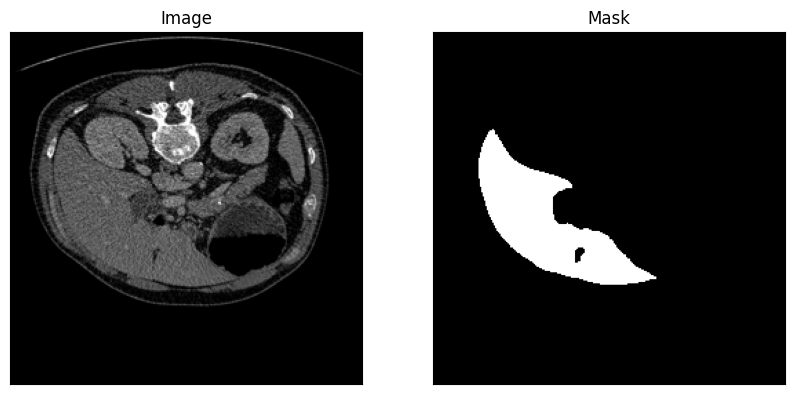

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# **1.2. CT Heart Dataset**

### Download Dataset

In [ ]:
!kaggle datasets download nikhilroxtomar/ct-heart-segmentation
!unzip -q ct-heart-segmentation.zip

Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/ct-heart-segmentation
License(s): unknown
100% 541M/541M [00:02<00:00, 214MB/s]
100% 541M/541M [00:02<00:00, 192MB/s]


### Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define the root path to the training data
root_dir = '/content/data/train'  # Root directory containing patient folders

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images and masks from a given patient ID
def load_images_and_masks(patient_id, target_size):
    images = []
    masks = []

    image_folder = os.path.join(root_dir, patient_id, 'image')
    mask_folder = os.path.join(root_dir, patient_id, 'mask')

    # Load images
    for filename in sorted(os.listdir(image_folder)):
        if filename.endswith('.png'):
            img_path = os.path.join(image_folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)

            # Load corresponding mask
            mask_filename = filename  # Masks share the same filename as images
            mask_path = os.path.join(mask_folder, mask_filename)

            if os.path.exists(mask_path):  # Ensure the mask file exists
                mask = Image.open(mask_path).convert('L')
                mask = mask.resize(target_size)  # Resize to the target size
                mask_np = np.array(mask)
                masks.append(mask_np)

    return np.array(images), np.array(masks)

# Initialize lists to hold all images and masks
all_images = []
all_masks = []

# Iterate over each patient folder (e.g., 100051, 100052, etc.)
for patient_folder in sorted(os.listdir(root_dir)):
    patient_path = os.path.join(root_dir, patient_folder)
    if os.path.isdir(patient_path):  # Check if it's a directory
        images, masks = load_images_and_masks(patient_folder, resize_to)
        all_images.append(images)
        all_masks.append(masks)

# Concatenate all images and masks from different patients
large_images = np.concatenate(all_images, axis=0)
large_masks = np.concatenate(all_masks, axis=0)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 2532 images of shape (256, 256) (HxW)
Loaded 2532 masks of shape (256, 256) (HxW)
Image shape: (952, 256, 256)
Mask shape: (952, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 952
})

### Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/heart_ct_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/heart_ct_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 952
})

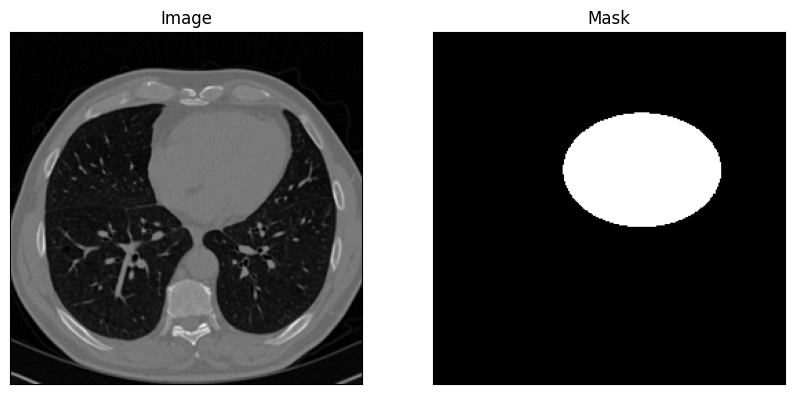

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# **1.3. MR-CT Brain Dataset**

### Download Dataset

In [ ]:
!kaggle datasets download oalkadi/unpaired-mr-ct-brain-dataset
!unzip -q unpaired-mr-ct-brain-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/oalkadi/unpaired-mr-ct-brain-dataset
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 91% 5.00M/5.50M [00:00<00:00, 46.3MB/s]
100% 5.50M/5.50M [00:00<00:00, 50.2MB/s]


### 1.3.1 CT

#### Create Dataset

In [ ]:
%%capture
!pip install pydicom

In [ ]:
import os
import numpy as np
import pydicom  # Import the pydicom library for handling DICOM files
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .dcm images
image_dir = '/content/JUH_MR-CT_dataset/CT/image_CT'  # Directory with DICOM files for images
mask_dir = '/content/JUH_MR-CT_dataset/CT/mask_CT'     # Directory with DICOM files for masks

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.dcm'):  # Check for .dcm files
            img_path = os.path.join(folder, filename)
            dcm = pydicom.dcmread(img_path)  # Read the DICOM file
            img = dcm.pixel_array  # Get the pixel array from the DICOM file
            img = Image.fromarray(img).convert('L')  # Convert to PIL image and grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 88 images of shape (256, 256) (HxW)
Loaded 88 masks of shape (256, 256) (HxW)
Image shape: (88, 256, 256)
Mask shape: (88, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 88
})

#### Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/ctbrain_mrct_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/ctbrain_mrct_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 88
})

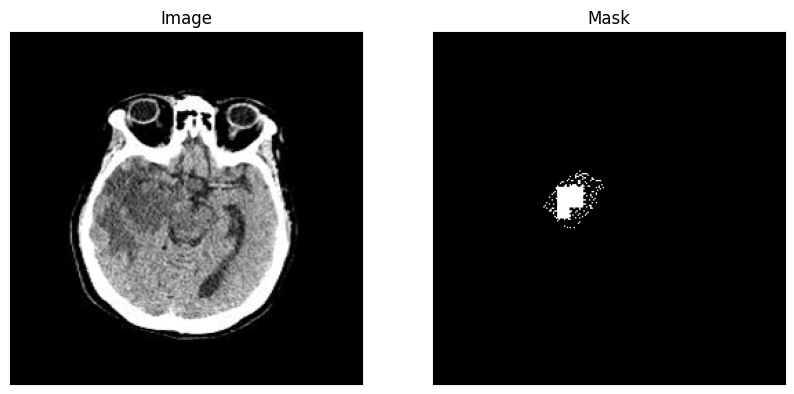

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

### 1.3.2 MRI

#### Create Dataset

In [ ]:
import os
import numpy as np
import pydicom  # Import the pydicom library for handling DICOM files
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .dcm images
image_dir = '/content/JUH_MR-CT_dataset/MR/image_MR'  # Directory with DICOM files for images
mask_dir = '/content/JUH_MR-CT_dataset/MR/mask_MR'     # Directory with DICOM files for masks

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.dcm'):  # Check for .dcm files
            img_path = os.path.join(folder, filename)
            dcm = pydicom.dcmread(img_path)  # Read the DICOM file
            img = dcm.pixel_array  # Get the pixel array from the DICOM file
            img = Image.fromarray(img).convert('L')  # Convert to PIL image and grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 90 images of shape (256, 256) (HxW)
Loaded 90 masks of shape (256, 256) (HxW)
Image shape: (90, 256, 256)
Mask shape: (90, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 90
})

#### Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/mrbrain_mrct_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/mrbrain_mrct_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 90
})

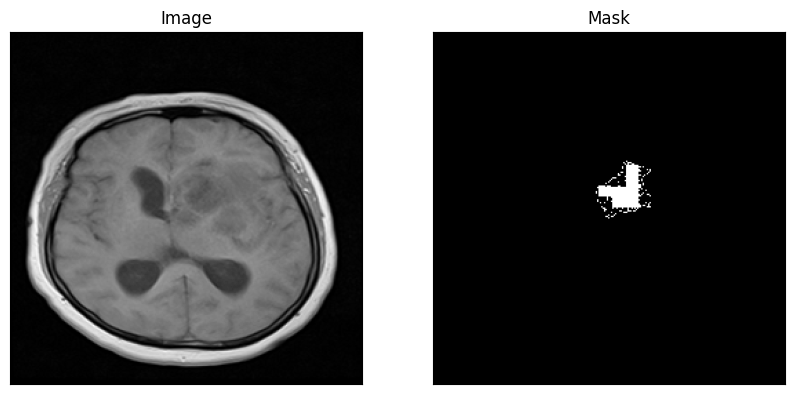

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()